## Regression Linear

### Let's predict the value of houses in Brooklyn


##### ***Data is extracted from ZIllow.com***

In [2]:
# Libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fastparquet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Load the data 
data = pd.read_parquet("Data/house_data.parquet")

# Checkpoint
df = pd.DataFrame(data)

In [4]:
# First 4 rows
df.head(4)

,zpid,Status Type,Status Text,Time On Zillow,Price,Area,Price Per Sqft,Zestimate,Zestimate Price Per Sqft,Rent Zestimate,...,Zipcode,Latitude,Longitude,Broker Name,is zillow owned,Sold Date,Sold Price,Image URL,Detail URL,Search Page URL
0,142972352,FOR_SALE,House for sale,NaN,4299999.0,5056.0,850.0,NaN,NaN,3157.0,...,11228,40.617516,-74.016030,Listing by: Jabour Realty Company,False,NaN,NaN,https://photos.zillowstatic.com/fp/370e173113c...,https://www.zillow.com/homedetails/1135-84th-S...,https://www.zillow.com/homes/for_sale/?searchQ...
1,30695325,FOR_SALE,House for sale,NaN,110000.0,1200.0,92.0,NaN,NaN,3112.0,...,11209,40.631010,-74.028230,Listing by: DiTommaso Real Estate,False,NaN,NaN,https://photos.zillowstatic.com/fp/ee817903ce8...,https://www.zillow.com/homedetails/7520-3rd-Av...,https://www.zillow.com/homes/for_sale/?searchQ...
2,30688987,FOR_SALE,Multi-family home for sale,NaN,1399000.0,2496.0,560.0,1368100.0,548.0,3051.0,...,11219,40.626682,-73.999090,Listing by: Remax Edge,False,NaN,NaN,https://photos.zillowstatic.com/fp/b873f115c1c...,https://www.zillow.com/homedetails/1339-63rd-S...,https://www.zillow.com/homes/for_sale/?searchQ...
3,30695805,FOR_SALE,Multi-family home for sale,NaN,995000.0,2952.0,337.0,1003500.0,340.0,2563.0,...,11209,40.630314,-74.027016,Listing by: Keller Williams Realty Staten Island,False,NaN,NaN,https://photos.zillowstatic.com/fp/8824e0f09db...,https://www.zillow.com/homedetails/334-76th-St...,https://www.zillow.com/homes/for_sale/?searchQ...


In [5]:
# Before we starts, we need to clean the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30773 entries, 0 to 31143
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   zpid                      28554 non-null  Int64  
 1   Status Type               30773 non-null  object 
 2   Status Text               30773 non-null  object 
 3   Time On Zillow            0 non-null      float64
 4   Price                     28531 non-null  float64
 5   Area                      17358 non-null  float64
 6   Price Per Sqft            17358 non-null  float64
 7   Zestimate                 15910 non-null  float64
 8   Zestimate Price Per Sqft  11082 non-null  float64
 9   Rent Zestimate            20975 non-null  float64
 10  Lot Area                  6110 non-null   float64
 11  Lot Area Unit             6119 non-null   object 
 12  Beds                      25651 non-null  float64
 13  Bathrooms                 27861 non-null  float64
 14  Address    

In [6]:
# Drop columns that are not needed
drop_columns = ['Time On Zillow',
                'is Zilow Owned',
                'Zestimate',
                'Zestimate Price Per Sqft',
                'Rent Zestimate',
                'Sold Date',
                'Sold Price', 
                'Broker Name', 
                'Detail URL', 
                'Search Page URL',
                'Lot Area',
                'Lot Area Unit',]

df = df.drop(drop_columns, axis=1, errors='ignore')

In [7]:
df.isna().sum()

zpid                2219
Status Type            0
Status Text            0
Price               2242
Area               13415
Price Per Sqft     13415
Beds                5122
Bathrooms           2912
Address                0
Street                 0
City                   0
State                  0
Zipcode                0
Latitude             738
Longitude            738
is zillow owned     2219
Image URL             46
dtype: int64

#### **Data Cleaning**

In [8]:
# Dropna the row `price`
df = df.dropna(subset=['Price', 'Latitude', 'Longitude'])

# # We fill the missing columns with the median
df.fillna({
    'Area'           : df['Area'].median(),
    'Price Per Sqft' : df['Price Per Sqft'].median(),
    'Bathrooms'      : df['Bathrooms'].median(),
    'Beds'           : df['Beds'].median()
}, inplace=True)

In [9]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,zpid,Price,Area,Price Per Sqft,Beds,Bathrooms,Zipcode,Latitude,Longitude
count,"27,793.00","27,793.00","27,793.00","27,793.00","27,793.00","27,793.00","27,793.00","27,793.00","27,793.00"
mean,"641,561,831.85","1,386,787.49","1,668.22",795.18,2.89,2.45,"10,744.38",40.71,-73.94
std,"807,541,546.89","3,629,758.81","2,086.24","5,646.48",2.50,14.05,832.53,0.08,0.14
min,"8,893,695.00",1.00,1.00,0.00,1.00,1.00,"6,460.00",39.64,-77.04
25%,"39,220,915.00","30,000.00","1,108.00",481.00,2.00,1.00,"10,030.00",40.66,-73.99
50%,"300,082,682.00","679,000.00","1,280.00",574.00,2.00,2.00,"11,201.00",40.73,-73.95
75%,"443,304,617.00","1,299,000.00","1,538.00",693.00,3.00,3.00,"11,237.00",40.77,-73.88
max,"2,146,935,717.00","150,000,000.00","125,782.00","579,000.00",114.00,"1,352.00","19,720.00",41.59,-73.01


In [10]:
df.isna().sum()

zpid               0
Status Type        0
Status Text        0
Price              0
Area               0
Price Per Sqft     0
Beds               0
Bathrooms          0
Address            0
Street             0
City               0
State              0
Zipcode            0
Latitude           0
Longitude          0
is zillow owned    0
Image URL          0
dtype: int64

In [11]:
# Only numeric columns
df_num = df.select_dtypes(include=[np.number])


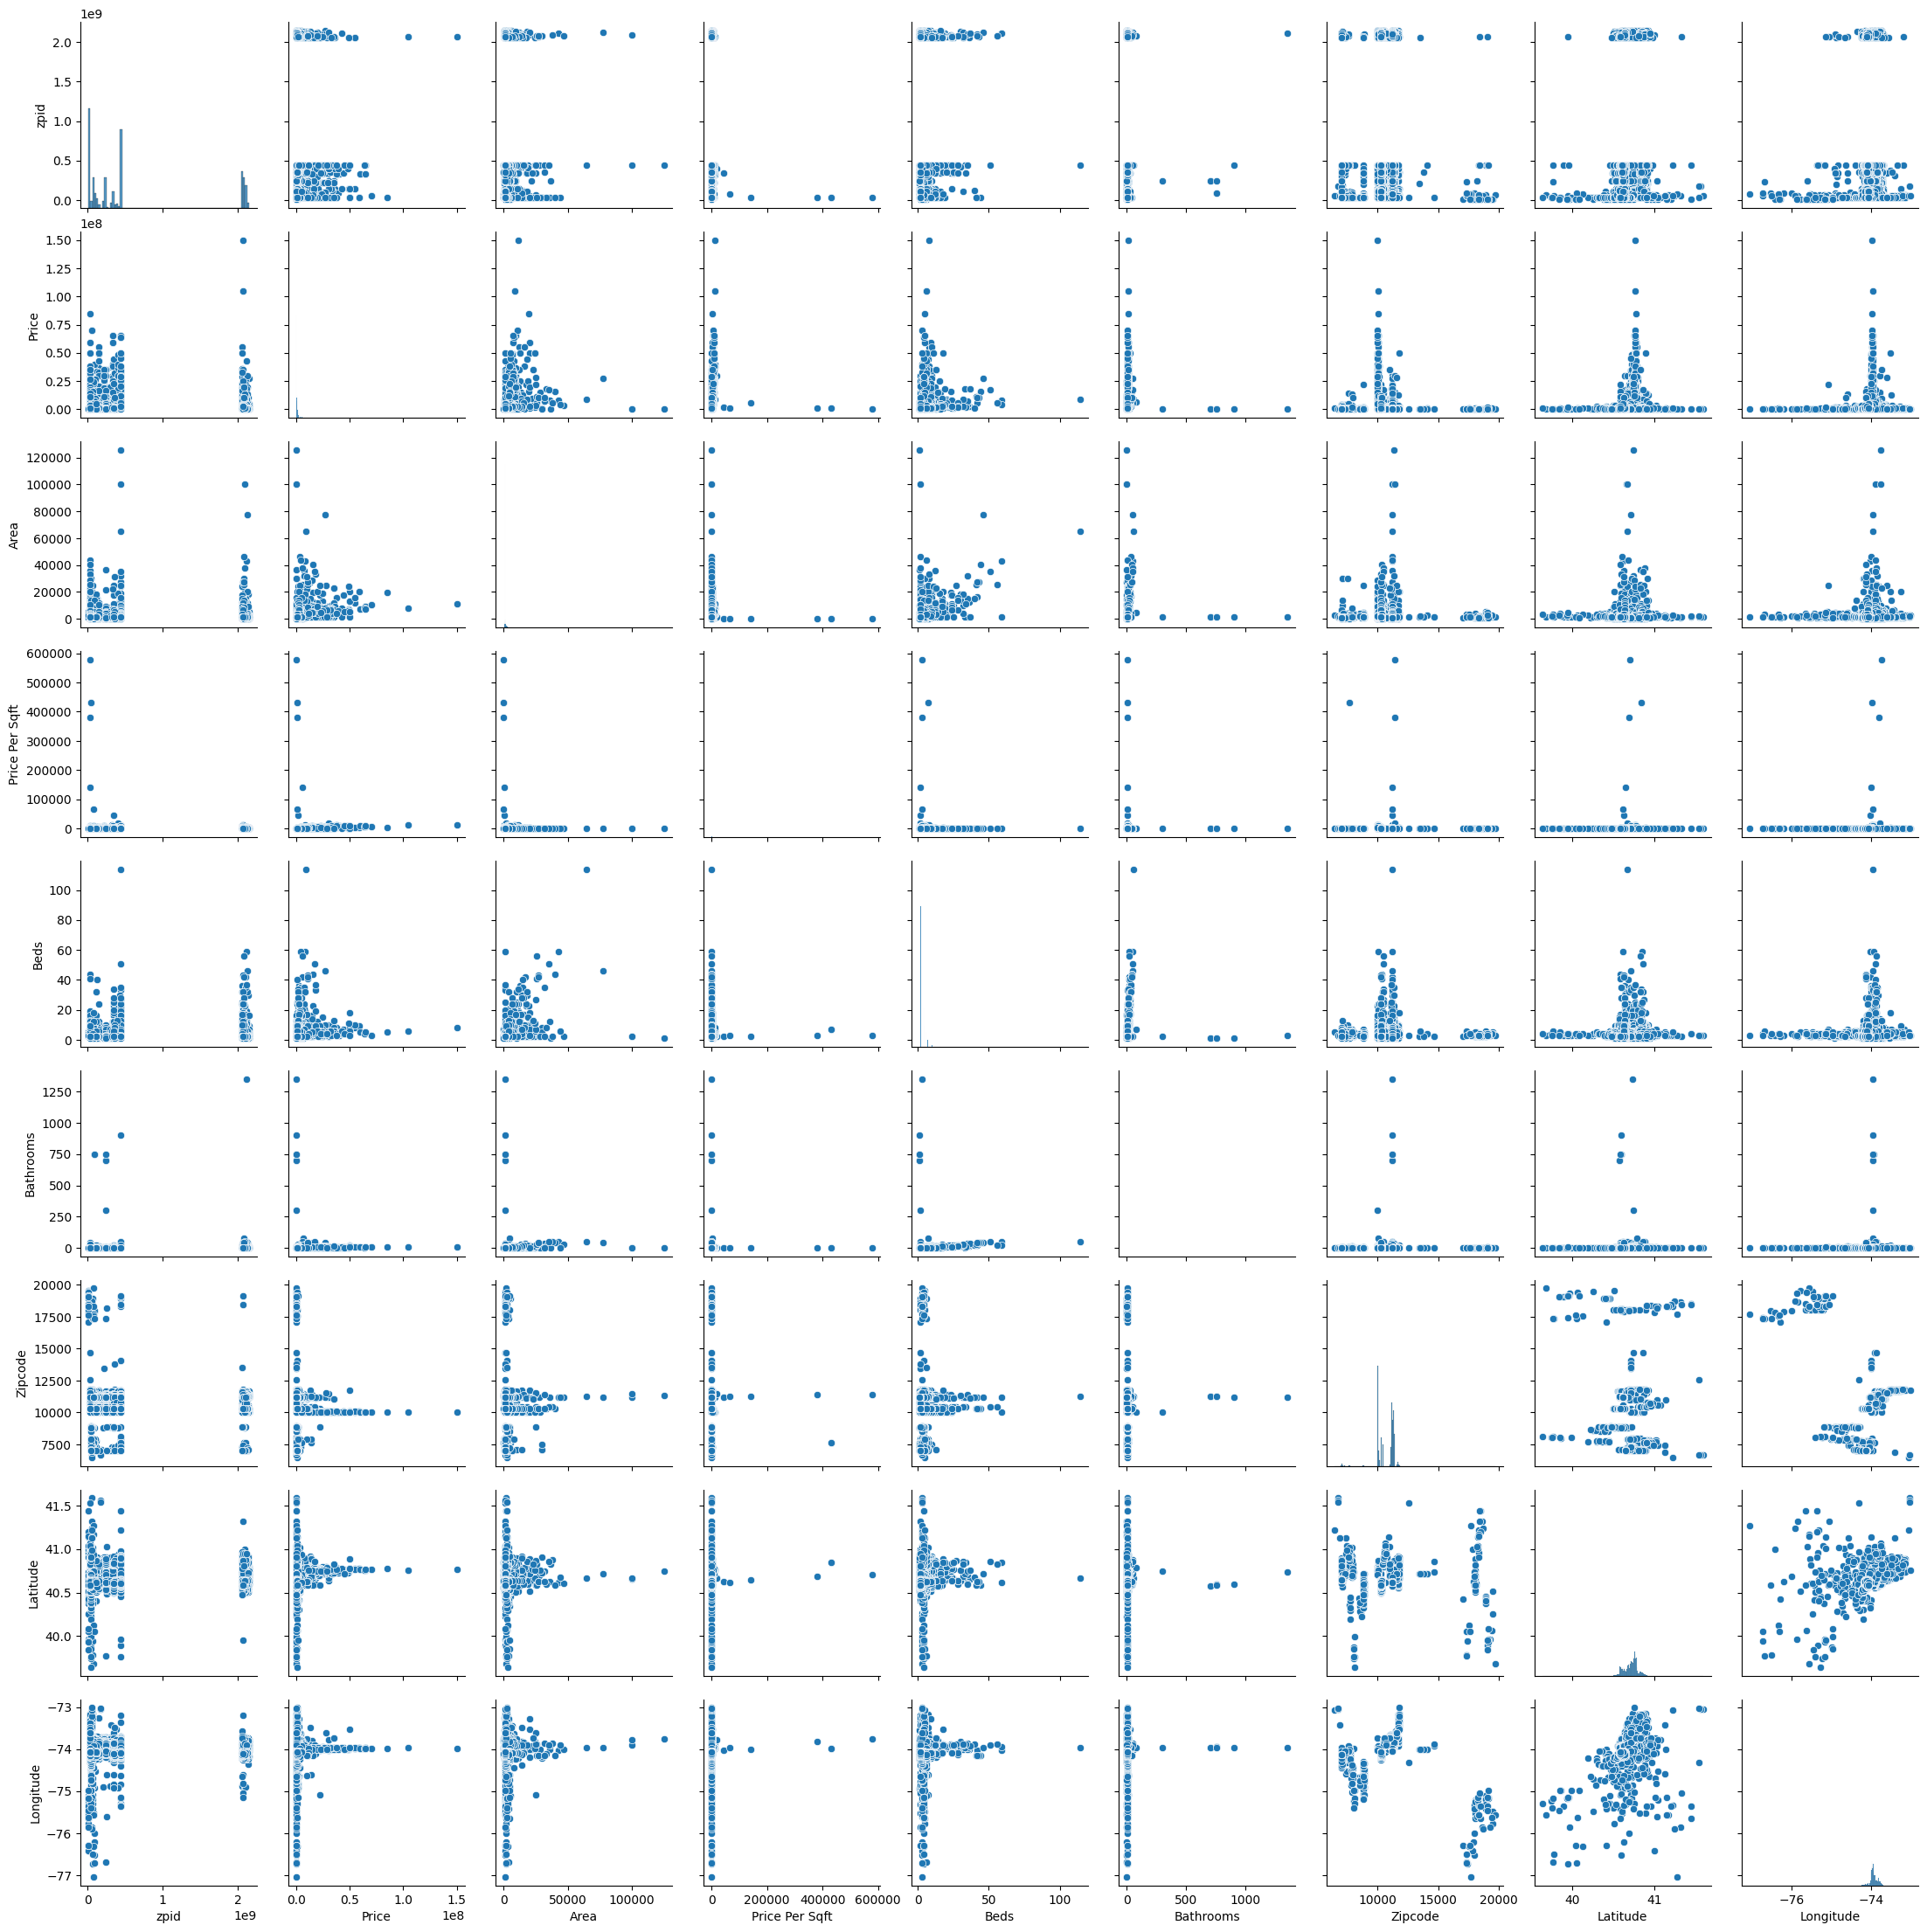

In [12]:
# Visualize the relationships
sns.pairplot(df_num)
plt.show()

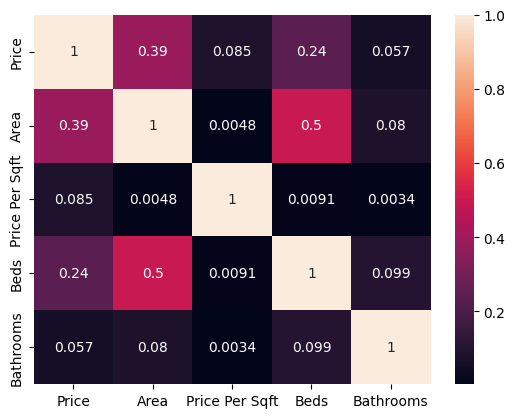

In [13]:
num_var =  df[['Price', 'Area', 'Price Per Sqft',
       'Beds', 'Bathrooms']]
# Correlation matrix
corr_matrix = num_var.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

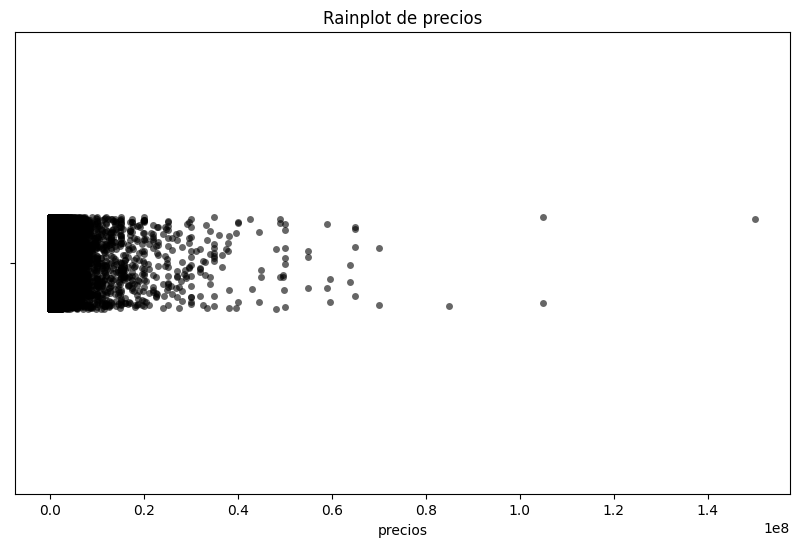

In [14]:
#  Visualize outliers in teh data `Price`  -AFTER-
plt.figure(figsize=(10,6))
sns.stripplot(x='Price', data=df, jitter=True, color='black', alpha=0.6)
plt.title("Rainplot de precios")
plt.xlabel("precios")
plt.show()

In [15]:
# Remove the outliers 
print(df['Price'].quantile(0.25))
print(df['Price'].quantile(0.75))

q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Price'] >= q1 - 1.5 * iqr) & (df['Price'] <= q3 + 1.5 * iqr)]

30000.0
1299000.0


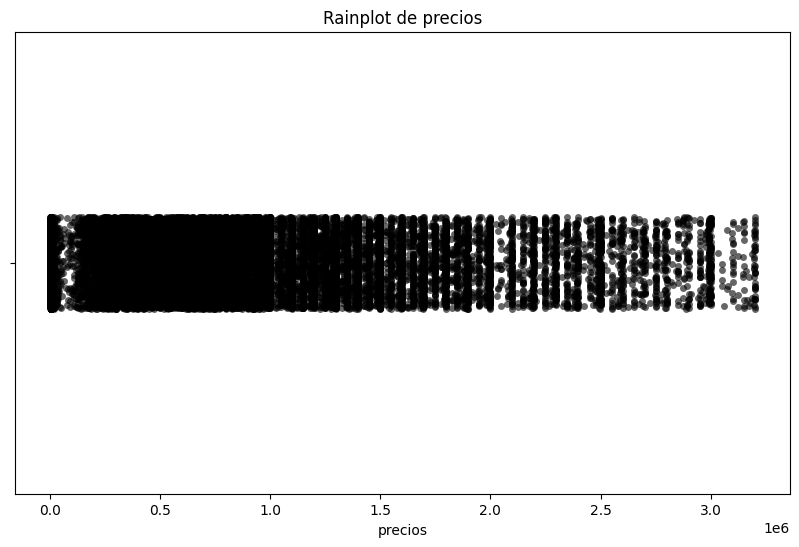

In [16]:
# Visualize outliers in teh data `Price`   -AFTER-
plt.figure(figsize=(10,6))
sns.stripplot(x='Price', data=df, jitter=True, color='black', alpha=0.6)
plt.title("Rainplot de precios")
plt.xlabel("precios")
plt.show()

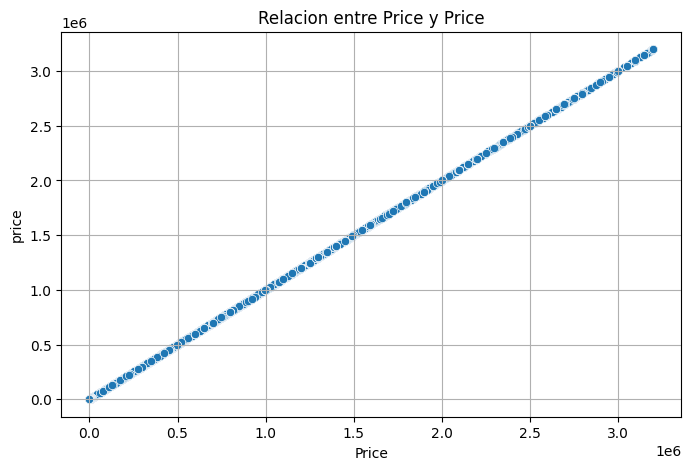

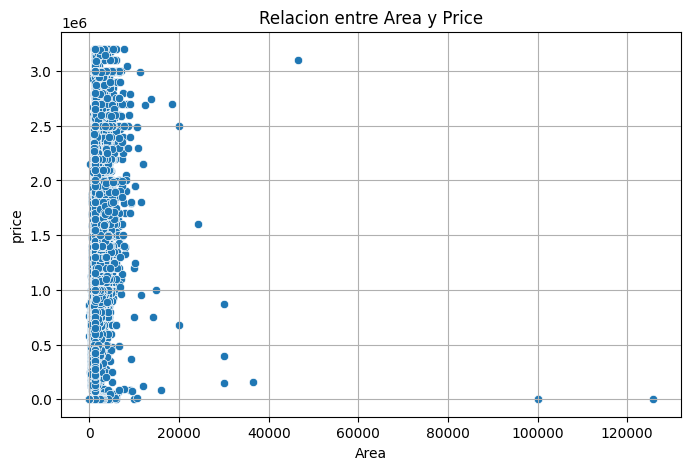

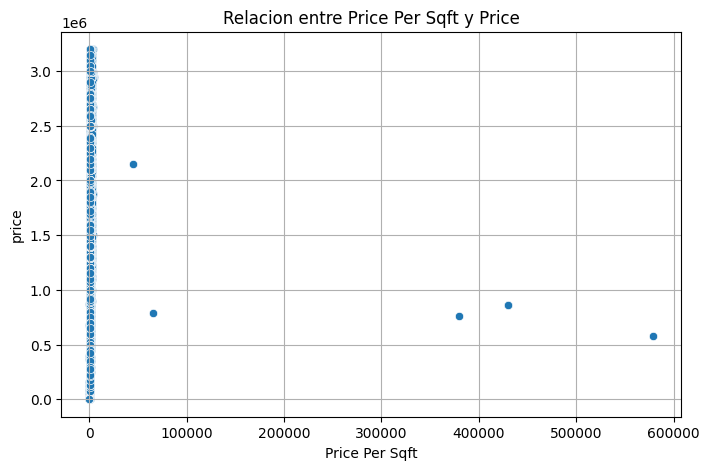

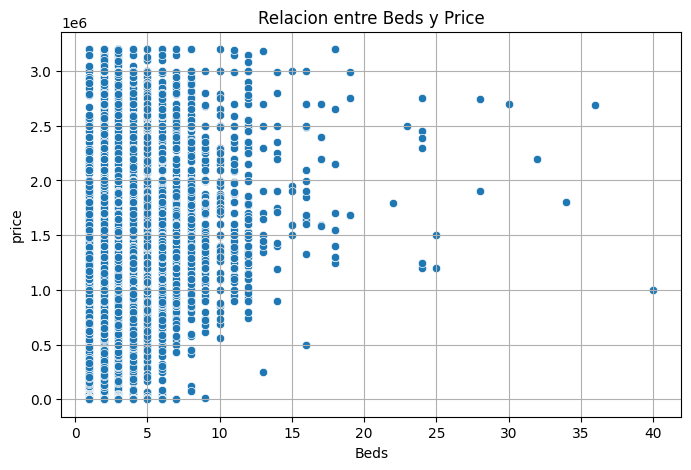

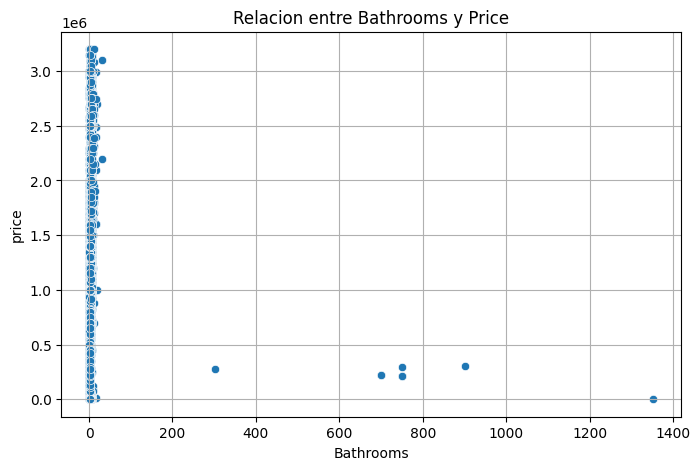

In [20]:
# Visualize the relationship between independdent and dependent variables
independent_vars = ['Price', 'Area', 'Price Per Sqft',
       'Beds', 'Bathrooms']

for var in independent_vars:
       plt.figure(figsize=(8, 5))
       sns.scatterplot(x=var, y='Price', data=df)
       plt.title(f'Relacion entre {var} y Price')
       plt.xlabel(var)
       plt.ylabel("price")
       plt.grid(True)
       plt.show()


In [47]:
var_beds = df['Beds']
print(var_beds.value_counts(ascending=True))

Beds
34       1
22       1
40       1
30       1
23       1
36       1
32       1
28       2
25       2
19       4
17       5
24       6
15       6
18      12
13      12
14      14
16      17
11      78
10      83
12      94
9      147
8      300
7      410
6      861
5     1142
4     2114
3     4977
1     6189
2     9149
Name: count, dtype: int64


In [46]:
# see the value counts of the column `Bathrooms`
var_bath = df['Bathrooms']
print(var_bath.value_counts(ascending=True))


Bathrooms
301         1
901         1
1352        1
20          2
32          2
701         2
17          2
14          3
751         3
13          4
11          6
16          8
12          8
10         19
9          22
8          76
7         111
6         382
5         662
4        1444
3        3317
2        7534
1       12021
Name: count, dtype: int64


<class 'pandas.core.series.Series'>


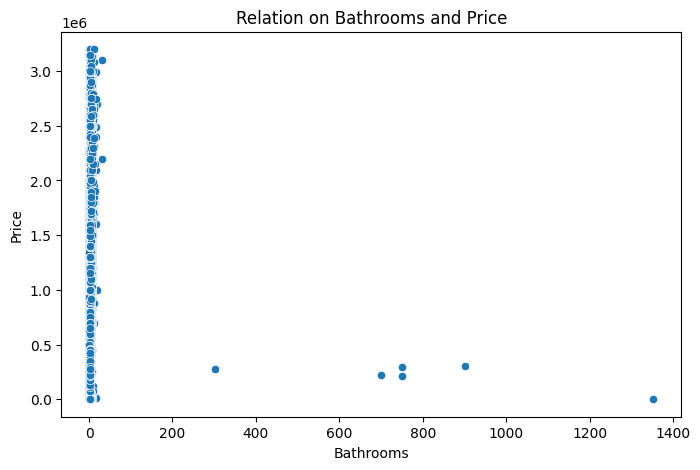

In [48]:
# Change the data type of the columns `Bathrooms` and `Beds`
df['Bathrooms'] = df['Bathrooms'].astype('int16')
df['Beds'] = df['Beds'].astype('int16')

# See the change in the scatter plot and data type
print(type(df['Bathrooms']))

plt.figure(figsize=(8, 5))
sns.scatterplot(x='Bathrooms', y='Price', data=df) 
plt.title("Relation on Bathrooms and Price")
plt.show()